<a href="https://colab.research.google.com/github/ldm2060/LearningNote/blob/main/DL%202023.6/week2/%E8%A7%86%E9%A2%91%E7%AC%94%E8%AE%B0/note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WEEK2

## 2.1 模型优化

### 2.1.1 模型优化通行步骤

```
graph TD
A[训练集Loss] -->|过大| B( )
B --> |模型偏差|C( 模型不够复杂)
B ---> |优化不好|D( 寻找最低loss 的演算法无法找到满足需要的优解)
A -->|过小| E[测试集Loss]
E -->|过大| F( )
E -->|过小| G( ^.^)
F --> |过拟合| H("模型过于满足训练数据（太灵活），不具有普遍性")
F --> |"错误匹配（Mismatching）"| I

```




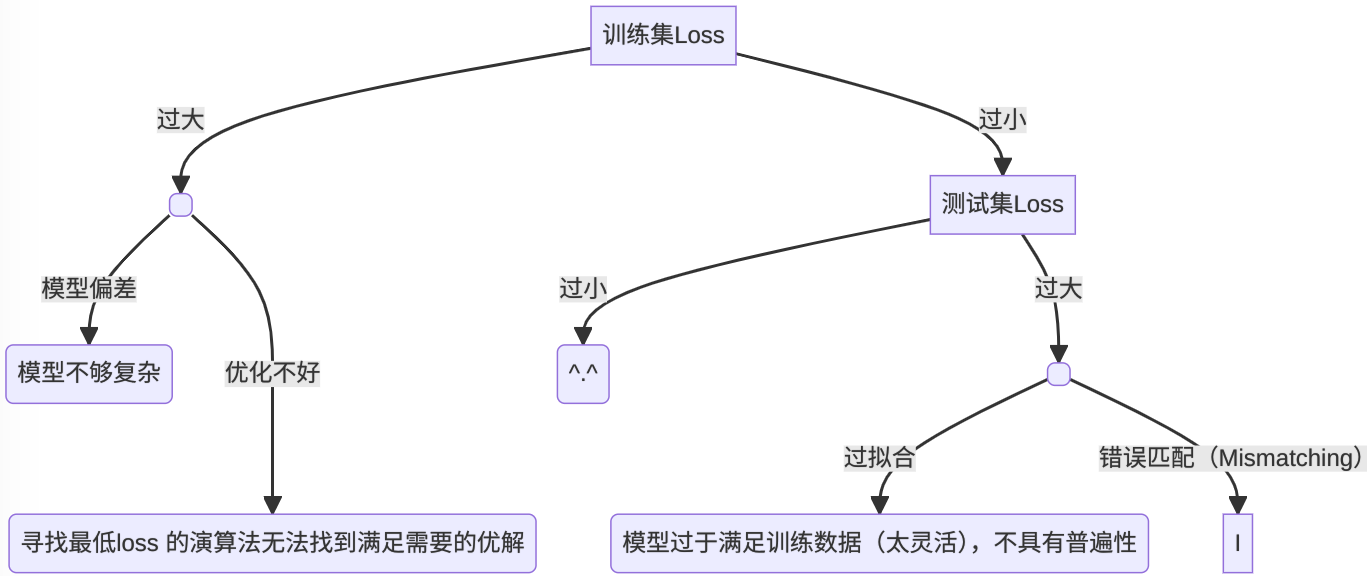

对于训练集Loss过大：

* 可以先从浅层次的模型（线性模型、SVM）起手构建，他们的优化较为简单

* DL中若更深层级的网络没有带来更小的Loss，则应考虑可能是优化性质的问题

对于过拟合问题：

* 使用更多的训练数据来训练
  * 收集更多数据
  * Data augmentation：基于已有数据进行合理变换创造新的数据
* 简化模型
  * 减少超参数等
  * less feature
  * 提前结束模型演化过程
  * 正则化（Regularization）
  * Dropout
* 限制太多，会导致回到model bias问题
* trade-off：将数据分为训练集和验证集，通过在验证集上的表现来选择模型

对于Mismatching问题：

- 通过训练集无法对测试集中出现的某些结果进行预测

- 训练集和测试集分布不一致



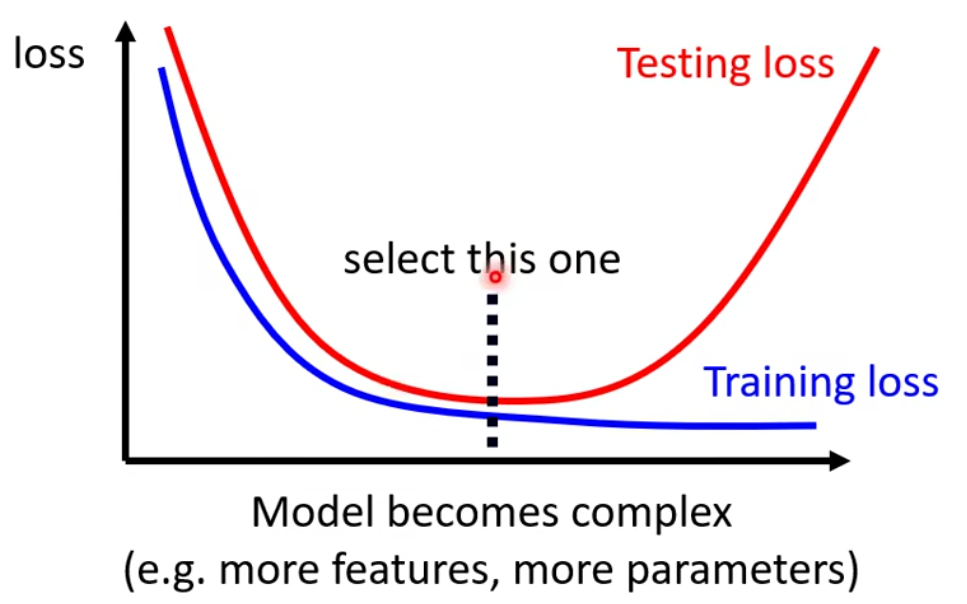

### 2.1.2 卡在 critical point

两种情况
- loss降不下去，但距离理想的值还有一段差距
- loss自训练起就居高不下
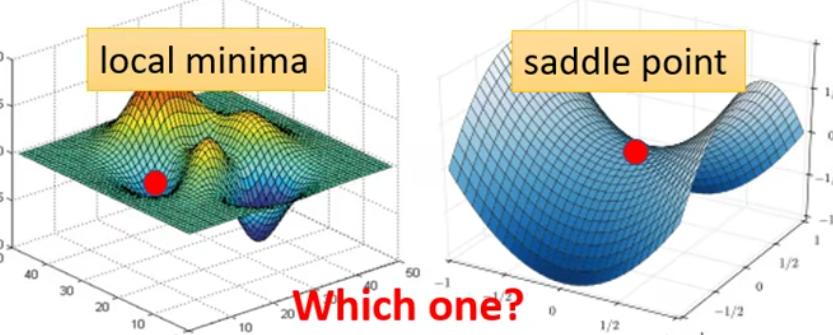

#### 2.1.2.1 计算海森矩阵（不常用）
泰勒二阶展开：$\begin{aligned}L\left( \theta \right) \approx L\left( \theta '\right) +\left( \theta -\theta '\right)^{T}g +\dfrac{1}{2}\times \left( \theta -\theta '\right) ^{T}H\left( \theta -\theta '\right) \end{aligned}$

- Gradient $g$ (vector)
- Hessian $H$ (matrix)：二阶偏导

当走到critical point时，梯度为0，$\begin{aligned}L\left( \theta \right) \approx L\left( \theta '\right) +\dfrac{1}{2}\times \left( \theta -\theta '\right) ^{T}H\left( \theta -\theta '\right) \end{aligned}$

这时通过二阶导数矩阵项来判断是local minima、local maxima 或是 saddle point

对于$s = \left( \theta -\theta '\right) ^{T}H\left( \theta -\theta '\right)$
- 总是$s > 0$：$L(\theta) > L(\theta')$,为local minima
- 总是$s < 0$：$L(\theta) < L(\theta')$,为local maxima
- $s$ 有时候大于 $0$ 有时候小于 $0$ ：为 saddle point

如何判断以上三种情况：直接看 $H$ 的正负来定 $s$ 的正负
- eigen value全正，则s总为正
- eigen value全负，则s总为负
- eigen value有正有负，则s有正有负

*eigen value（特征值）

设 $\lambda$为特征值，当$\lambda < 0$，沿着其对应的特征向量方向update会得到更小值

即$\theta = \theta' + u$，$u$为特征向量

原理：
  - $\theta - \theta' = u$
  - $\left( \theta -\theta '\right) ^{T}H\left( \theta -\theta '\right) = u^THu=u^T(\lambda u)= \lambda ||u||^2$
  - 当$\lambda < 0$，式子$ < 0$，$L(\theta)<L( \theta ')$

猜想：在高纬度的error surface中，local minima/maxima 很少

#### 2.1.2.2 Batch（Mini Batch）

每个batch作为一个处理单位，模型训练完一个batch以后计算Loss并更新超参数

1 epoch = 所有batches都处理过一次

Shuffle：每次epoch后重新分batch

Full Batch：$Batch size = n$，即不分Batch的情况（数据集整体为一个batch）
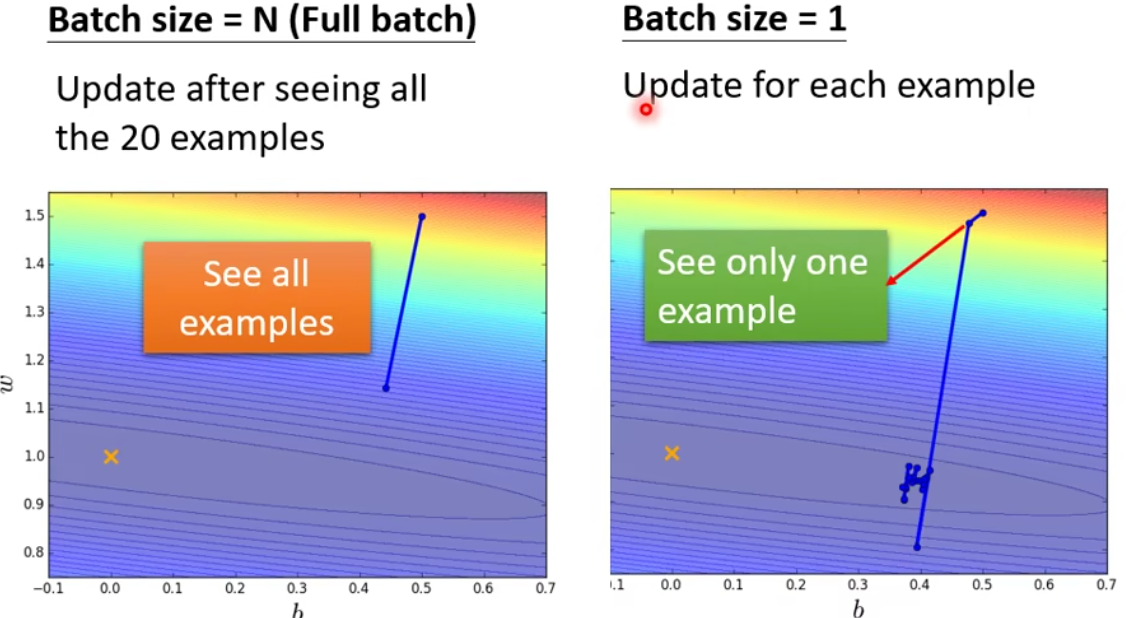




可以看到：
- Batch size大：powerful，相对慢（非并行计算加速型）
- Batch size小：noisy，相对快（非并行计算加速型）

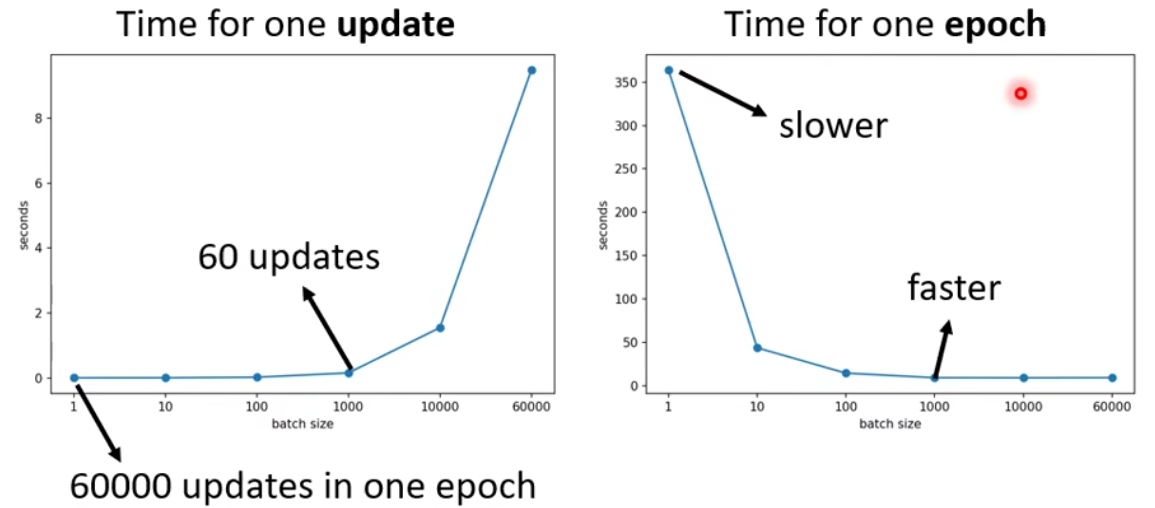

通过比较发现，更大batch size的模型（只要不是特别大）并不一定需要更长时间来进行梯度下降优化，比如实际执行使用了并行计算

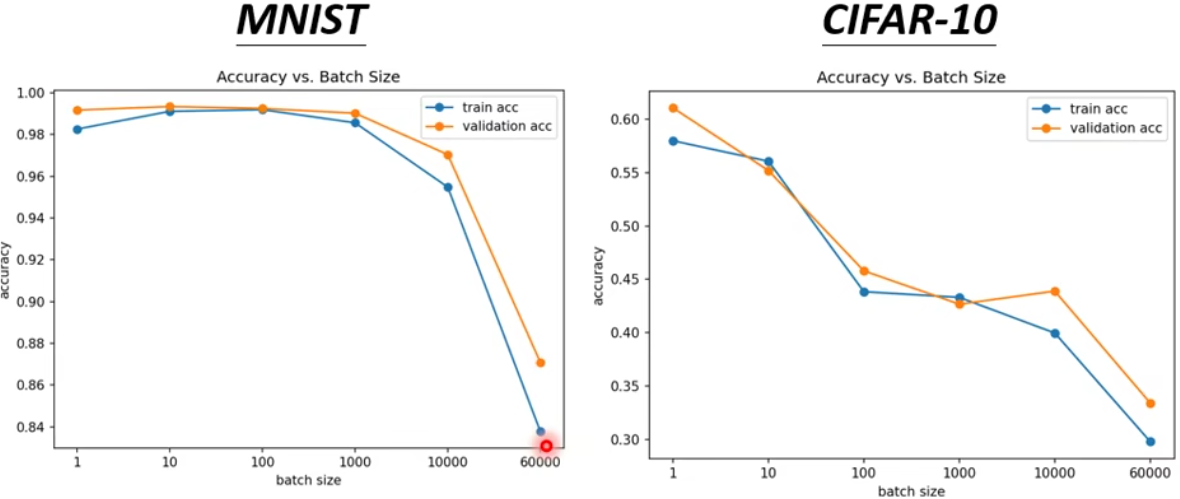

大的batch size对模型优化反而会产生负面影响

小的batch size，其训练过程中的noisy反而有利于模型训练
- 猜想：每次训练的Loss不一样，不容易卡在critical point

小的batch size，即使训练Loss和大的batch size差不多，最终模型效果也可能比大的好
- 猜想：小的batch size能够更好的规避坏的local minima

  坏的local minima：例如处于峡谷中的minima。其和处于平原的minima相比而言，左右移动后Loss又会快速上升

#### 2.1.2.3 Momentum（动量）

在error surface中进行梯度下降，把平面想象成物理世界的平面，当下降到local minima后，因为惯性点会继续移动，也许可以翻越local minima附近的小坡到达一个更低的local minima

移动步数考虑为梯度+前一次移动步数

步骤：
- Starting at $\theta_0 $
- Movement $m_0= 0$
- Compute gradient $g_0$
- Movement $m_1 = \lambda m_0 -\eta g_0$
- Move to $\theta_1 = \theta_0+ m_1$
- Compute gradient $g_1$
- Movement $m_2 = \lambda m_1 - \eta g_1$
- Move to $\theta_2 = \theta_1+ m_2$
- ...

### 2.1.3 Adaptive Learning Rate

卡住峡谷型critical point，因为learning rate大导致训练在critical point左右移动而不能到达

- 在平缓的error surface我们需要大的learning rate来加速在平地行走过程
- 在陡峭的error surface我们需要小的learning rate来贴合下降的趋势（而不至于跳过一个峡谷）

怎么判断平缓还是陡峭：通过梯度

用公式表示：$\begin{aligned}\theta _{i}^{t+1}\leftarrow \theta _{i}^{t}-\dfrac{\lambda}{\sigma_{i}^t}g_{i}^{t} \end{aligned}$

$\theta _{i}$：第i+1个参数，$\lambda$：学习率，$g_i$：对$\theta _{i}$的偏导（梯度），$\sigma_{i}^t$：自适应学习率需要的额外参数

$\sigma_{i}^t$可采用Root Mean Square计算：$\sigma _{i}^{t}=\sqrt{\dfrac{1}{t+1}
\sum ^{t+1}_{j=0}\left( g_{i}^{j}\right) ^{2}}$

考虑动态决定当前梯度对学习率的重要性：RMSProp

$\sigma _{i}^{0}=\sqrt{( g_{i}^{0}) ^{2}}$

$\sigma _{i}^{t}=\sqrt{ \alpha (\sigma _{i}^{t-1})^2+(1-\alpha )(g_{i}^{t}) ^{2}}$，$t \neq 0, 0 <\alpha <1$

一个实例：$Adam$，RMSProp + Momentum

Learning Rate Scheduling：$\begin{aligned}\theta _{i}^{t+1}\leftarrow \theta _{i}^{t}-\dfrac{\lambda^t}{\sigma_{i}^t}g_{i}^{t} \end{aligned}$
- 即学习率不固定，亦为一个参数
- Learning Rate Decay：随着训练的进行，越来越接近目标点，因此学习率从大变小
- Warm UP：学习率先变大再变小（不是一开始就变小）
  - 一开始对$\sigma$统计不精准， 因此一开始不需要走得很快
  - 参考RAdam

